In [1]:
#Load the dependancies
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.medical.imaging import *

import pydicom
import seaborn as sns

import numpy as np
import pandas as pd
import os

In [2]:
source = Path("data")
files = os.listdir(source)
print(files)

['tfrecords', 'jpeg', 'test', 'sample_submission.csv', 'train.csv', 'train', 'test.csv']


In [3]:
df = pd.read_csv(source/'train.csv')
test_df = pd.read_csv(source/'test.csv')

df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [4]:
train = source/'train'
train_files = get_dicom_files(train)
train_files

(#33126) [Path('data/train/ISIC_2152755.dcm'),Path('data/train/ISIC_7331382.dcm'),Path('data/train/ISIC_2945640.dcm'),Path('data/train/ISIC_3251405.dcm'),Path('data/train/ISIC_5192265.dcm'),Path('data/train/ISIC_2365745.dcm'),Path('data/train/ISIC_6927363.dcm'),Path('data/train/ISIC_5582679.dcm'),Path('data/train/ISIC_4200673.dcm'),Path('data/train/ISIC_0488413.dcm')...]

In [5]:
patient1 = train_files[7]
dimg = dcmread(patient1)

In [6]:
dimg

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 220
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.99.1.7737.1034.1589911715735.1.1.0.0.0
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.99.2
(0002, 0013) Implementation Version Name         SH: 'PIXELMEDJAVA001'
(0002, 0016) Source Application Entity Title     AE: 'OURAETITLE'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.99.3
(0008, 0016) SOP Class UID                       UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0008, 0018) SOP Instance UID                    UI: 

In [7]:
def show_one_patient(file):
    """ function to view patient image and choosen tags within the head of the DICOM"""
    pat = dcmread(file)
    print(f'patient Name: {pat.PatientName}')
    print(f'Patient ID: {pat.PatientID}')
    print(f'Patient age: {pat.PatientAge}')
    print(f'Patient Sex: {pat.PatientSex}')
    print(f'Body part: {pat.BodyPartExamined}')
    trans = Transform(Resize(256))
    dicom_create = PILDicom.create(file)
    dicom_transform = trans(dicom_create)
    return show_image(dicom_transform)

patient Name: "ISIC^5582679"
Patient ID: "ISIC_5582679"
Patient age: 050Y
Patient Sex: M
Body part: TORSO


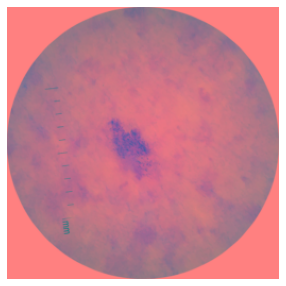

In [8]:
show_one_patient(patient1)

In [9]:
from pydicom.pixel_data_handlers.util import convert_color_space

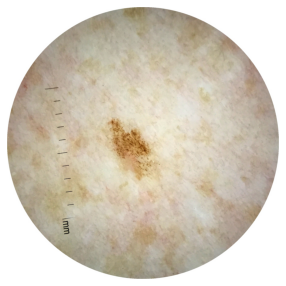

In [10]:
arr = dimg.pixel_array
convert = convert_color_space(arr, 'YBR_FULL_422', 'RGB')
show_image(convert)

(array([1.567000e+03, 3.640000e+02, 9.260000e+02, 6.860500e+04,
        2.462184e+06, 4.011719e+06, 8.714360e+05, 8.177610e+05,
        5.676630e+05, 7.136580e+05]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ], dtype=float32),
 <a list of 10 Patch objects>)

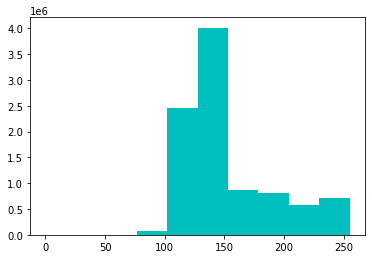

In [11]:
px = dimg.pixels.flatten()
plt.hist(px, color='c')

In [12]:
class PILDicom2(PILBase):
    _open_args,_tensor_cls,_show_args = {},TensorDicom,TensorDicom._show_args
    @classmethod
    def create(cls, fn:(Path,str,bytes), mode=None)->None:
        "Open a `DICOM file` from path `fn` or bytes `fn` and load it as a `PIL Image`"
        dimg = dcmread(fn)
        arr = dimg.pixel_array; convert = convert_color_space(arr,'YBR_FULL_422', 'RGB')
        im = Image.fromarray(convert)
        im.load()
        im = im._new(im.im)
        return cls(im.convert(mode) if mode else im)

In [13]:
melanoma = DataBlock(
            blocks    = (ImageBlock(cls=PILDicom), CategoryBlock(vocab=[0,1])),
            get_x     = lambda x:source/'train'/f'{x[0]}.dcm',
            splitter  = RandomSplitter(valid_pct=0.2, seed=42),
            item_tfms = Resize(128),
            get_y     = ColReader('target'),
            batch_tfms=aug_transforms(flip_vert   = True,
                                      max_lighting= 0.1,
                                      max_zoom    = 1.05,
                                      max_warp    = 0.))

In [14]:
#dls = melanoma.dataloaders(df.sample(100), bs=2)
dls = melanoma.dataloaders(df, bs=8)

In [17]:
dls.one_batch()

(TensorDicom([[[[0.5896, 0.6131, 0.6140,  ..., 0.7257, 0.7392, 0.7472],
           [0.5898, 0.6039, 0.6005,  ..., 0.7290, 0.7314, 0.7392],
           [0.5841, 0.5918, 0.5981,  ..., 0.7192, 0.7375, 0.7414],
           ...,
           [0.6927, 0.6986, 0.6910,  ..., 0.5643, 0.5681, 0.5618],
           [0.6963, 0.7006, 0.6981,  ..., 0.5659, 0.5665, 0.5618],
           [0.7080, 0.7072, 0.7078,  ..., 0.5631, 0.5698, 0.5630]],
 
          [[0.4300, 0.4320, 0.4281,  ..., 0.4292, 0.4308, 0.4372],
           [0.4252, 0.4251, 0.4250,  ..., 0.4284, 0.4274, 0.4378],
           [0.4175, 0.4249, 0.4247,  ..., 0.4257, 0.4297, 0.4378],
           ...,
           [0.4294, 0.4301, 0.4289,  ..., 0.4090, 0.4108, 0.4082],
           [0.4297, 0.4334, 0.4294,  ..., 0.4083, 0.4089, 0.4082],
           [0.4294, 0.4330, 0.4304,  ..., 0.4083, 0.4117, 0.4092]],
 
          [[0.5569, 0.5545, 0.5586,  ..., 0.5447, 0.5438, 0.5412],
           [0.5614, 0.5582, 0.5620,  ..., 0.5447, 0.5442, 0.5416],
           [0.5658,

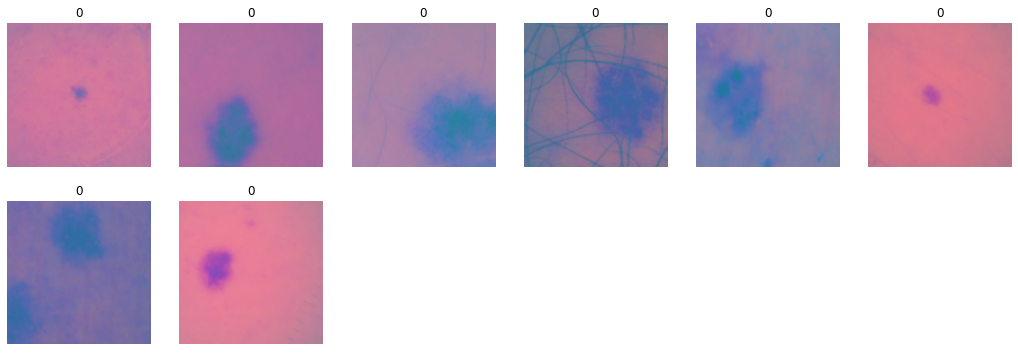

In [18]:
dls.show_batch(max_n=12, nrows=2, ncols=6)

In [19]:
dls = dls.cuda()

In [20]:
dls.one_batch()

(TensorDicom([[[[1.0714e-01, 4.1849e-02, 7.8491e-03,  ..., 2.1208e-07,
            2.1208e-07, 2.1208e-07],
           [2.0455e-01, 1.0481e-01, 3.1101e-02,  ..., 2.1208e-07,
            2.1208e-07, 2.1208e-07],
           [2.6914e-01, 1.5384e-01, 8.8803e-02,  ..., 2.1208e-07,
            2.1208e-07, 2.1208e-07],
           ...,
           [7.7938e-01, 7.8446e-01, 8.0611e-01,  ..., 6.4926e-01,
            5.8066e-01, 5.9064e-01],
           [8.3272e-01, 8.2246e-01, 8.2750e-01,  ..., 6.1487e-01,
            5.8539e-01, 6.8624e-01],
           [8.3892e-01, 8.2644e-01, 8.2542e-01,  ..., 5.7398e-01,
            6.7857e-01, 7.9967e-01]],
 
          [[5.3941e-01, 5.3547e-01, 5.2816e-01,  ..., 5.2445e-01,
            5.2445e-01, 5.2445e-01],
           [5.3943e-01, 5.3738e-01, 5.3305e-01,  ..., 5.2445e-01,
            5.2445e-01, 5.2445e-01],
           [5.3217e-01, 5.3243e-01, 5.3397e-01,  ..., 5.2445e-01,
            5.2445e-01, 5.2445e-01],
           ...,
           [5.2307e-01, 5.2177e-0

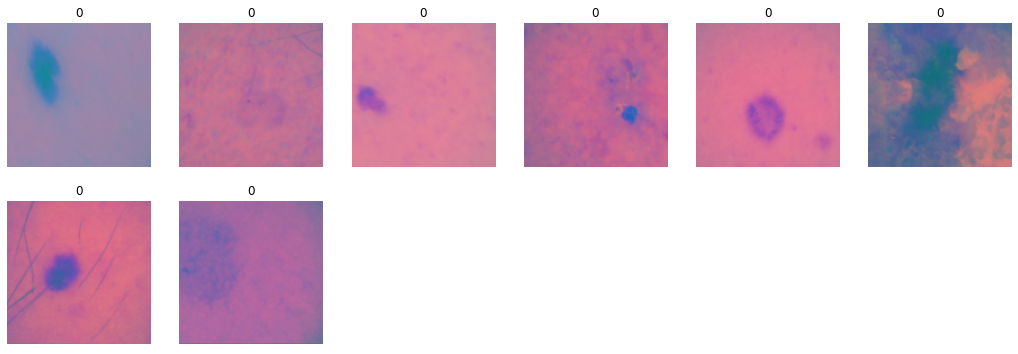

In [21]:
dls.show_batch(max_n=12, nrows=2, ncols=6)

In [22]:
model = xresnet18_deeper(n_out=dls.c)

In [23]:
set_seed(77)
learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy, RocAuc()],
                cbs = ShowGraphCallback())

In [24]:
learn.freeze()
learn.fit_one_cycle(1, 5e-2)

IndexError: list index out of range